In [6]:
import torch
from torch import nn 
import matplotlib.pyplot as plt

torch.__version__

'2.7.1+cu128'

In [13]:
# Create known params 
weight = 0.7
bias = 0.3

# Create data
start, end = 0, 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [14]:
# Create train/test split 
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)


(40, 40, 10, 10)

In [17]:
def plot_predictions(train_data=X_train,
                    train_labels=y_train,
                    test_data=X_test,
                    test_labels=y_test,
                    predictions=None):
    plt.figure(figsize=(10, 7))

    # plot training data in blue
    plt.scatter(train_data, train_labels, c="b", label="Traning data")

    # plot test data in green 
    plt.scatter(test_data, test_labels, c="g", label="Test data")

    if predictions is not None:
        plt.scatter(test_data, predictions, c="r", label="Predictions")

    plt.legend(prop={"size": 14});

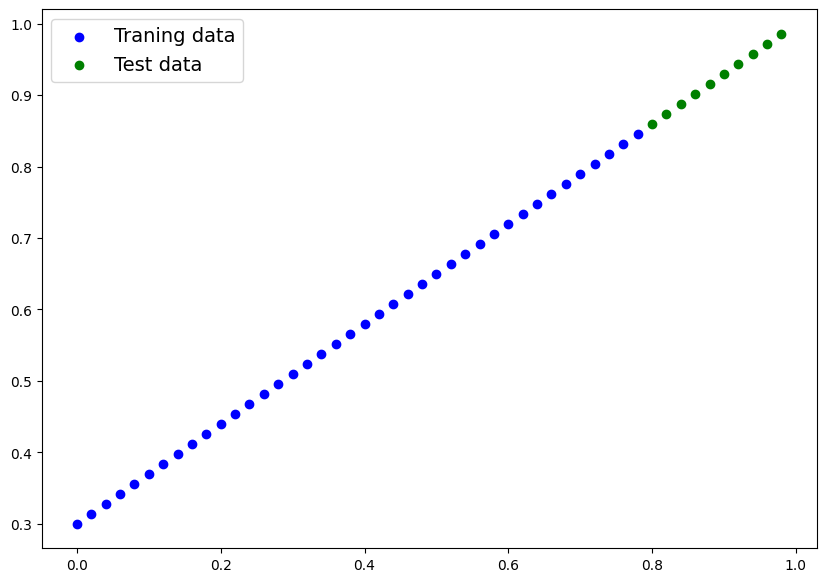

In [19]:
plot_predictions()

In [29]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.rand(1, dtype=torch.float), requires_grad=True)
        self.bias = nn.Parameter(torch.rand(1, dtype=torch.float), requires_grad=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias

## Checking the contents of a Pytorch model


In [30]:
torch.manual_seed(42)

model_0 = LinearRegressionModel()

list(model_0.parameters())

[Parameter containing:
 tensor([0.8823], requires_grad=True),
 Parameter containing:
 tensor([0.9150], requires_grad=True)]

In [31]:
# List named params 
model_0.state_dict()

OrderedDict([('weights', tensor([0.8823])), ('bias', tensor([0.9150]))])

## Making predictions using torch.inference_mode()
* You probably noticed we used torch.inference_mode() as a context manager (that's what the with torch.inference_mode(): is) to make the predictions.
* As the name suggests, torch.inference_mode() is used when using a model for inference (making predictions)
* torch.inference_mode() turns off a bunch of things (like gradient tracking, which is necessary for training but not for inference) to make forward-passes (data going through the forward() method) faster

In [32]:
# Make predictions with model
with torch.inference_mode():
    y_preds = model_0(X_test)
    

In [33]:
# Check the predictions
print(f"Number of testing samples: {len(X_test)}") 
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")

Number of testing samples: 10
Number of predictions made: 10
Predicted values:
tensor([[1.6208],
        [1.6385],
        [1.6561],
        [1.6738],
        [1.6914],
        [1.7090],
        [1.7267],
        [1.7443],
        [1.7620],
        [1.7796]])


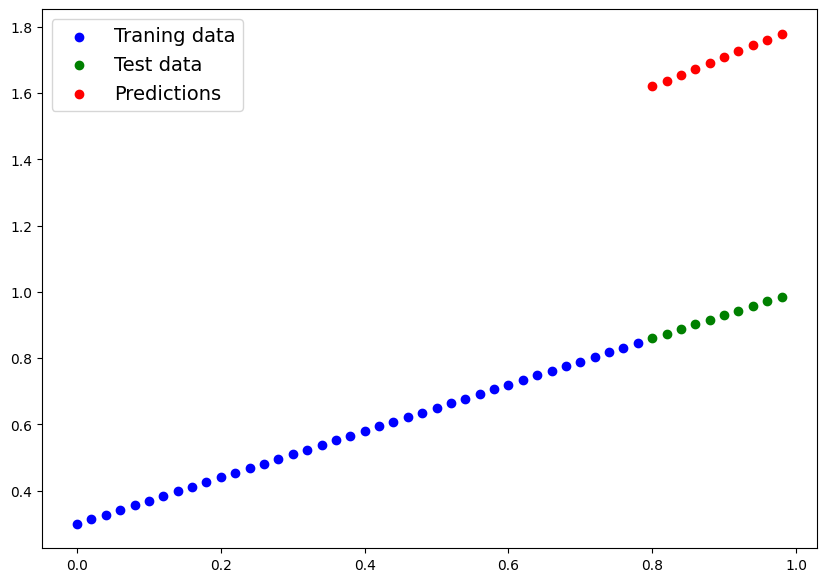

In [35]:
plot_predictions(predictions=y_preds)

In [36]:
y_test - y_preds

tensor([[-0.7608],
        [-0.7645],
        [-0.7681],
        [-0.7718],
        [-0.7754],
        [-0.7790],
        [-0.7827],
        [-0.7863],
        [-0.7900],
        [-0.7936]])

# 3. Train model
* For our model to update its parameters on its own, we'll need to add a few more things to our recipe
* And that's a loss function as well as an optimizer.

In [37]:
# Create the loss function
loss_fn = nn.L1Loss() # MAE loss is name as L1Loss

# Create the optimizer 
optimizer = torch.optim.SGD(params=model_0.parameters(), 
                           lr=0.01)

### Creating an optimization loop in PyTorch

In [38]:
torch.manual_seed(42)

# set number of epoches (how many times the model will pass over the training data)
epochs = 100

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ### Training 

    # Put the model in training mode (This is the default state of a model)
    model_0.train()

    # 1. Foward pass on train data using the forward() method inside 
    y_pred = model_0(X_train)

    # 2. Cal the loss
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad of the optimizer
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Progress the optimizer 
    optimizer.step()

    ### Testing 

    # Put the model in evaluation mode 
    model_0.eval()

    with torch.inference_mode():
        # 1 Forward pass on the test data
        test_pred = model_0(X_test)

        # 2. Cal the loss on test data
        test_loss = loss_fn(test_pred, y_test.type(torch.float)) # predictions come in torch.float type, so comparisions need to be done with tensors of the same type

        # Print the loss values
        if epoch % 10 == 0:
            epoch_count.append(epoch)
            #  creates a tensor that shares storage with tensor that does not require grad. 
            #  It detaches the output from the computational graph. So no gradient will be backpropagated along this variable
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

Epoch: 0 | MAE Train Loss: 0.6860889196395874 | MAE Test Loss: 0.7637526988983154 
Epoch: 10 | MAE Train Loss: 0.5708791017532349 | MAE Test Loss: 0.6290428042411804 
Epoch: 20 | MAE Train Loss: 0.45566922426223755 | MAE Test Loss: 0.4943329691886902 
Epoch: 30 | MAE Train Loss: 0.34045934677124023 | MAE Test Loss: 0.35962313413619995 
Epoch: 40 | MAE Train Loss: 0.2252494841814041 | MAE Test Loss: 0.2249133139848709 
Epoch: 50 | MAE Train Loss: 0.1100396141409874 | MAE Test Loss: 0.09020347893238068 
Epoch: 60 | MAE Train Loss: 0.009724985808134079 | MAE Test Loss: 0.020998019725084305 
Epoch: 70 | MAE Train Loss: 0.006216754671186209 | MAE Test Loss: 0.014099234715104103 
Epoch: 80 | MAE Train Loss: 0.002788322512060404 | MAE Test Loss: 0.005826681852340698 
Epoch: 90 | MAE Train Loss: 0.007095950655639172 | MAE Test Loss: 0.00754010071977973 


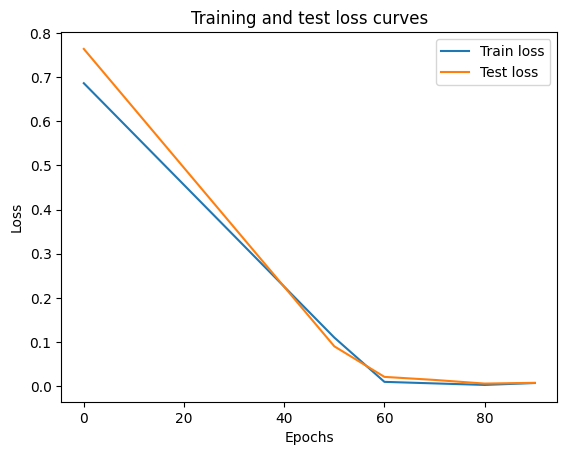

In [40]:
import matplotlib.pyplot as plt
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();

In [41]:
print("The model learned the following values for weights and bias:")
print(model_0.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict({'weights': tensor([0.6977]), 'bias': tensor([0.3080])})

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


## 4. Making predictions with a trained PyTorch model (inference)
#### There are three things to remember when making predictions (also called performing inference) with a PyTorch model:

* Set the model in evaluation mode (model.eval()).
* Make the predictions using the inference mode context manager (with torch.inference_mode(): ...).
* All predictions should be made with objects on the same device (e.g. data and model on GPU only or data and model on CPU only).

In [42]:
# Set the model in valuation mode
model_0.eval()

# Set up inference mode context manager
with torch.inference_mode():
  # 3. Make sure the calculations are done with the model and data on the same device
  # in our case, we haven't setup device-agnostic code yet so our data and model are
  # on the CPU by default.
  # model_0.to(device)
  # X_test = X_test.to(device)
  y_preds = model_0(X_test)
y_preds

tensor([[0.8661],
        [0.8801],
        [0.8940],
        [0.9080],
        [0.9220],
        [0.9359],
        [0.9499],
        [0.9638],
        [0.9778],
        [0.9917]])

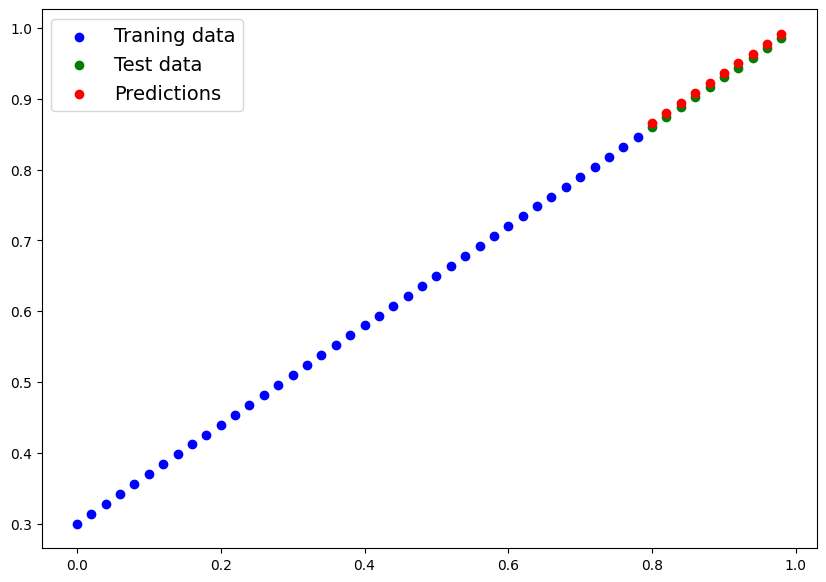

In [43]:
plot_predictions(predictions=y_preds)

# Saving and loading a Pytorch model
* torch.save	Saves a serialized object to disk using Python's pickle utility. Models, tensors and various other Python objects like dictionaries can be saved using torch.save.
* torch.load	Uses pickle's unpickling features to deserialize and load pickled Python object files (like models, tensors or dictionaries) into memory. You can also set which device to load the object to (CPU, GPU etc).
* torch.nn.Module.load_state_dict	Loads a model's parameter dictionary (model.state_dict()) using a saved state_dict() object.
* Note: As stated in Python's pickle documentation, the pickle module is not secure. That means you should only ever unpickle (load) data you trust. That goes for loading PyTorch models as well. Only ever use saved PyTorch models from sources you trust

In [44]:
from pathlib import Path

# Create models repo
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True) # Create sub directories if need and don't show error if the repo exists 

MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), 
          f=MODEL_SAVE_PATH)

Saving model to: models\01_pytorch_workflow_model_0.pth


In [51]:
# Check the saved file path
!ls -l models/01_pytorch_workflow_model_0.pth

'ls' is not recognized as an internal or external command,
operable program or batch file.


### Loading a saved PyTorch model's state_dict()

In [52]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model_0 = LinearRegressionModel() 

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [53]:
loaded_model_0.eval()

with torch.inference_mode():
    loaded_model_0_preds = loaded_model_0(X_test)


In [55]:
# Compare previous model predictions with loaded model predictions (these should be the same)
y_preds == loaded_model_0_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

# 6. Putting all together


In [57]:
import torch 
from torch import nn
import matplotlib.pyplot as plt 

torch.__version__

'2.7.1+cu128'

In [58]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [59]:
# Create weight and bias
weight = 0.7
bias = 0.3

# Create range values
start = 0
end = 1
step = 0.02

# Create X and y (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias 
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [61]:
# Split data
train_split = int(len(X) * 0.8)
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

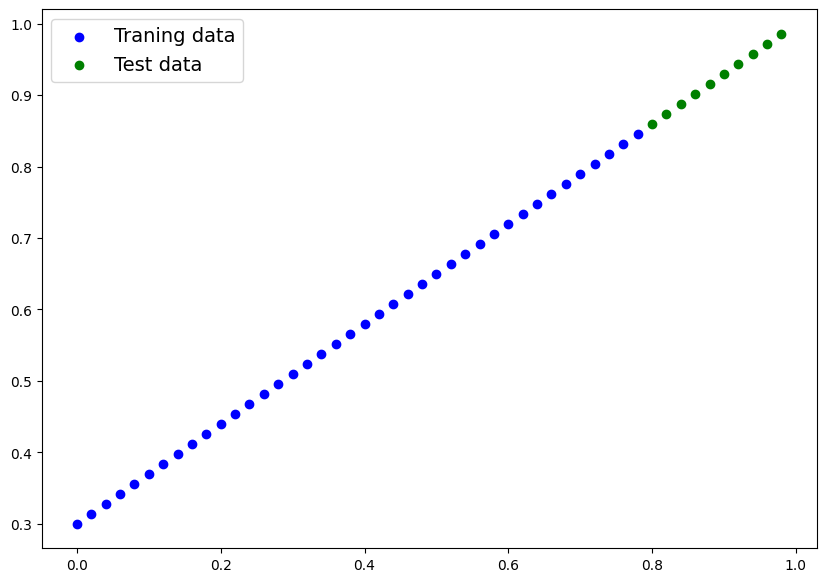

In [62]:
plot_predictions(X_train, y_train, X_test, y_test)

### 6.2 Building a PyTorch linear model
* We'll create the same style of model as before except this time, instead of defining the weight and bias parameters of our model manually using nn.Parameter(), we'll use nn.Linear(in_features, out_features) to do it for us
* Where in_features is the number of dimensions your input data has and out_features is the number of dimensions you'd like it to be output to.
* In our case, both of these are 1 since our data has 1 input feature (X) per label (y)

In [63]:
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        # Use nn.Linear() for creating the model parameters
        self.linear_layer = nn.Linear(in_features=1,
                                     out_features=1)
    # Define the forward computation (input data x flows through nn.Linear())
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [71]:
# Check model device
next(model_1.parameters()).device

device(type='cpu')

In [73]:
# Set model to GPU if it's available, otherwise it'll default to CPU
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

### Training

In [74]:
# Create loss fucntion MAE
loss_fn = nn.L1Loss()

# Create optimizer 
optimizer = torch.optim.SGD(params=model_1.parameters(),
                           lr=0.01)

In [80]:
torch.manual_seed(42)

# set number of epochs 
epochs = 1000
# Put data on the available device
# Without this, error will happen (not all model/data on device)
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    ### Training 
    model_1.train() # train mode is on by default after construction

    # Forward part 
    y_pred = model_1(X_train)

    # Cal loss
    loss = loss_fn(y_pred, y_train)

    # Zero grad optimizer (avoid affect from the prev epoch)
    optimizer.zero_grad()

    # propagation 
    loss.backward()

    # update params 
    optimizer.step()

    ### Testing 
    model_1.eval()
    with torch.inference_mode():
        test_pred = model_1(X_test)

        # Cal loss
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Train loss: 0.5436570048332214 | Test loss: 0.560505211353302
Epoch: 100 | Train loss: 0.005878167692571878 | Test loss: 0.012984705157577991
Epoch: 200 | Train loss: 0.010256479494273663 | Test loss: 0.00033081771107390523
Epoch: 300 | Train loss: 0.010256479494273663 | Test loss: 0.00033081771107390523
Epoch: 400 | Train loss: 0.010256479494273663 | Test loss: 0.00033081771107390523
Epoch: 500 | Train loss: 0.010256479494273663 | Test loss: 0.00033081771107390523
Epoch: 600 | Train loss: 0.010256479494273663 | Test loss: 0.00033081771107390523
Epoch: 700 | Train loss: 0.010256479494273663 | Test loss: 0.00033081771107390523
Epoch: 800 | Train loss: 0.010256479494273663 | Test loss: 0.00033081771107390523
Epoch: 900 | Train loss: 0.010256479494273663 | Test loss: 0.00033081771107390523


In [85]:
from pprint import pprint 
print("The model learned the following values for weights and bias:")
pprint(model_1.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('linear_layer.weight', tensor([[0.6929]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.2925], device='cuda:0'))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3
